In [1]:
# Real life data

import logging
import threading
import json
import itertools
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import ibm_db
import shap

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance

from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func
from iotfunctions import base
from iotfunctions import bif
from iotfunctions.db import Database
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.enginelog import EngineLogging
from iotfunctions.dbtables import FileModelStore
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from iotfunctions.dbtables import FileModelStore, DBModelStore
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore, GBMRegressor, SimpleRegressor)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn import metrics
import scipy as sp
import scipy.fftpack
#import skimage as ski  
#from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

In [2]:
'''
with open('credentials_as_monitor_demo.json', encoding='utf-8') as F:
    credentials = json.loads(F.read())
    
db_schema=None
db = Database(credentials=credentials)
print (db)
db_schema=None
fm = FileModelStore()
db = Database(credentials=credentials, model_store=fm)
print (db)
'''
db_schema=None
class DatabaseDummy:
    tenant_id = '###_IBM_###'
    db_type = 'db2'
    model_store = FileModelStore('./')
    def _init(self):
        return

db = DatabaseDummy()
        
print (db.tenant_id)

2021-11-12T12:51:46.057 INFO iotfunctions.dbtables.__init__ Init FileModelStore with path: ./
###_IBM_###


In [4]:
df_input_raw = pd.read_csv('./data/BVData.csv', comment='#') #, index_col=False, parse_dates=['DATETIME'], comment='#')
df_input_raw = df_input_raw.drop(columns=['Unnamed: 0']).\
    rename(columns={'Unnamed: 1':'timestamp'})

df_input_raw = df_input_raw.iloc[1: , :]
df_input_raw['timestamp'] = pd.to_datetime(df_input_raw['timestamp'])
#df_input_raw['deviceid'] = 'mydevice'

In [5]:
df_input_raw

,timestamp,Unit 2\AMBIENT TEMPERATURE,ID Fan A\ID Fan 1Status (2=ON1=OFF),ID Fan A\IDF A FLUE GAS INLET TEMP,ID Fan A\FLUE GAS FLOW (SIDE A),ID Fan A\IDF A BLADE POSN DEMAND,ID Fan A\ID Fan 1Pressure Rise Actual
1,2016-01-01 06:00:00,44.5185547,2,314.324219,690.773438,66.9082,29.3205566
2,2016-01-01 07:00:00,43.777832,2,305.828125,685.625,69.2568359,31.3203125
3,2016-01-01 08:00:00,44.1640625,2,311.5664,656.6797,67.39258,29.81836
4,2016-01-01 09:00:00,43.550293,2,312.839844,618.210938,64.05176,27.2988281
5,2016-01-01 10:00:00,41.47754,2,310.90625,627.375,63.88379,27.54126
...,...,...,...,...,...,...,...
8730,2016-12-31 02:00:00,39.730957,2,313.789063,726.46875,74.66797,35.30127
8731,2016-12-31 03:00:00,39.4667969,2,312.273438,723.039063,73.5625,34.78955
8732,2016-12-31 04:00:00,39.1098633,2,311.734375,726.6172,73.4834,34.76953
8733,2016-12-31 05:00:00,38.5214844,2,311.667969,727.6875,73.40527,34.7993164


In [6]:
df_input = df_input_raw.set_index(['timestamp'])
for col in df_input.columns.tolist():
    df_input[col] = pd.to_numeric(df_input[col])
features = df_input.columns.tolist()[:-1]
targets = df_input.columns.tolist()[-1:]
predictions = ['Pressure Rise Expected']

In [7]:
targets

['ID Fan A\\ID Fan 1Pressure Rise Actual']

In [8]:
features.remove('ID Fan A\\ID Fan 1Status (2=ON1=OFF)')

In [9]:
features

['Unit 2\\AMBIENT TEMPERATURE',
 'ID Fan A\\IDF A FLUE GAS INLET TEMP',
 'ID Fan A\\FLUE GAS FLOW (SIDE A)',
 'ID Fan A\\IDF A BLADE POSN DEMAND']

In [10]:
df_input[df_input['ID Fan A\\ID Fan 1Status (2=ON1=OFF)'] == 1] = np.nan

In [11]:
df_input.interpolate(method='spline', order=3)

,Unit 2\AMBIENT TEMPERATURE,ID Fan A\ID Fan 1Status (2=ON1=OFF),ID Fan A\IDF A FLUE GAS INLET TEMP,ID Fan A\FLUE GAS FLOW (SIDE A),ID Fan A\IDF A BLADE POSN DEMAND,ID Fan A\ID Fan 1Pressure Rise Actual
timestamp,,,,,,
2016-01-01 06:00:00,44.518555,2.0,314.324219,690.773438,66.908200,29.320557
2016-01-01 07:00:00,43.777832,2.0,305.828125,685.625000,69.256836,31.320312
2016-01-01 08:00:00,44.164062,2.0,311.566400,656.679700,67.392580,29.818360
2016-01-01 09:00:00,43.550293,2.0,312.839844,618.210938,64.051760,27.298828
2016-01-01 10:00:00,41.477540,2.0,310.906250,627.375000,63.883790,27.541260
...,...,...,...,...,...,...
2016-12-31 02:00:00,39.730957,2.0,313.789063,726.468750,74.667970,35.301270
2016-12-31 03:00:00,39.466797,2.0,312.273438,723.039063,73.562500,34.789550
2016-12-31 04:00:00,39.109863,2.0,311.734375,726.617200,73.483400,34.769530


In [12]:
# cleaning outliers - metrics below threshold are sensor issues
df_input[df_input[targets[0]] < -10.0] = -10.0
df_input = df_input.fillna(method='bfill')

#df_input[targets[0]][1134] = 34.722168

In [13]:
df_input.reset_index(inplace=True)
df_input['entity'] = 'mydevice'
df_input.set_index(['entity','timestamp'], inplace=True)

In [14]:
# Run Monitoring's anomaly detector functions
EngineLogging.configure_console_logging(logging.INFO)


gbmii = GBMRegressor(features=features, max_depth=20, num_leaves=40,
                     n_estimators=400, learning_rate=0.2, targets=targets,
                     predictions=predictions)
gbmii.correlation_threshold = 0.001
gbmii.experiments_per_execution = 3
gbmii.num_rounds_per_estimator = 3
gbmii.cv = 3

jobsettings = { 'db': db, 
               '_db_schema': 'public', 'save_trace_to_file' : True}
et = gbmii._build_entity_type(columns = [Column('Unit 2\AMBIENT TEMPERATURE',Float())], **jobsettings)
gbmii._entity_type = et

# allow training and delete existing models
gbmii.auto_train = True
gbmii.delete_existing_models = True
df_input = gbmii.execute(df=df_input)

2021-11-12T12:52:06.775 INFO iotfunctions.metadata.__init__ The entity type is not connected to a metric input table.
2021-11-12T12:52:06.779 ERROR iotfunctions.base.get_bucket_name Could not find credentials for entity type. COS read/write is disabled 
2021-11-12T12:52:06.780 INFO iotfunctions.base.delete_models Model names to delete: ['model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\\ID Fan 1Pressure Rise Actual.mydevice']
2021-11-12T12:52:06.780 INFO iotfunctions.dbtables.delete_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\ID Fan 1Pressure Rise Actual.mydevice has been deleted from filesystem
2021-11-12T12:52:06.781 INFO iotfunctions.base.get_models_for_training predicting target ID Fan A\ID Fan 1Pressure Rise Actual
2021-11-12T12:52:06.781 INFO iotfunctions.dbtables.retrieve_model Model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\ID Fan 1Pressure Rise Actual.mydevice does not exist in filesystem
2021-11-12T12:52:06.781 INFO iotfunctions

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM]

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.000193 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4658, number of used features: 4
[LightGBM] [Info] Start training from score 30.745960
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM]

2021-11-12T12:52:08.065 INFO iotfunctions.base.find_best_model Trained model no: 0 score:0.9853704338604027
2021-11-12T12:52:08.080 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\ID Fan 1Pressure Rise Actual.mydevice with evaluation metric value 0.7606961289743629
1
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.000206 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4658, number of used features: 4
[LightGBM] [Info] Start training from score 30.643830
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Tra

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] 

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000003 seconds, init for row-wise cost 0.000171 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4658, number of used features: 4
[LightGBM] [Info] Start training from score 30.745960
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM]

2021-11-12T12:52:09.329 INFO iotfunctions.base.find_best_model Trained model no: 1
2021-11-12T12:52:09.383 INFO iotfunctions.base.find_best_model Trained model no: 1 score:0.9853704338604027
2021-11-12T12:52:09.397 INFO iotfunctions.metadata.test evaluated model model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\ID Fan 1Pressure Rise Actual.mydevice with evaluation metric value 0.7606961289743629
1
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.000000
[LightGBM] [Debug] init for col-wise cost 0.000004 seconds, init for row-wise cost 0.000167 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 4658, number of used features: 4
[LightGBM] [Info] Start training from score 30.643830
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[Ligh

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 9
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] 

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM]

[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 40 and depth = 14
[LightGBM]

In [15]:
len(df_input)

8734

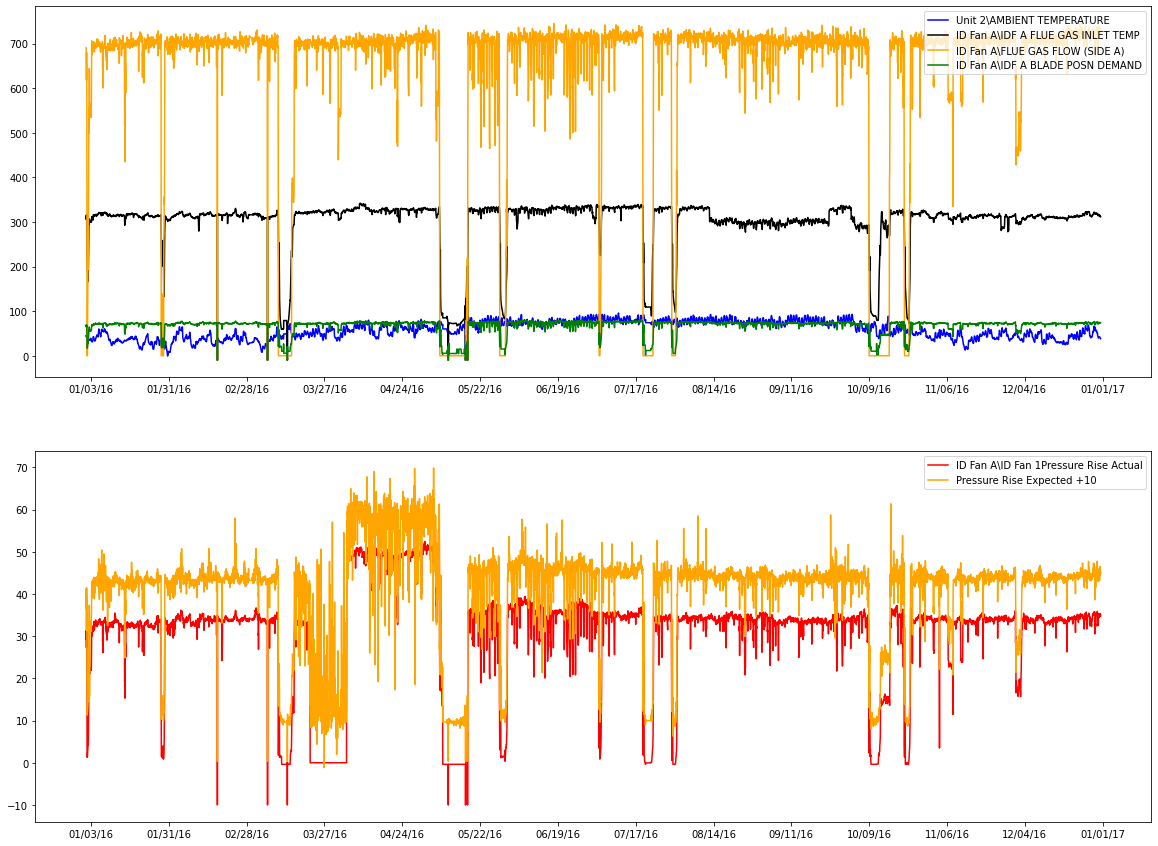

In [16]:
df = df_input.reset_index()
Range = slice(0,10000)
fig, ax = plt.subplots(2,1,figsize=(20,15),squeeze=False)

ax[0,0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=28))
ax[0,0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))
ax[1,0].xaxis.set_major_locator(matplotlib.dates.DayLocator(interval=28))
ax[1,0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%D'))

ax[0,0].plot(df[Range]['timestamp'], df[Range][features[0]], color='blue', label=features[0])
ax[0,0].plot(df[Range]['timestamp'], df[Range][features[1]], color='black', label=features[1])
ax[0,0].plot(df[Range]['timestamp'], df[Range][features[2]], color='orange', label=features[2])
ax[0,0].plot(df[Range]['timestamp'], df[Range][features[3]], color='green', label=features[3])
#ax[0,0].plot(df[Range]['timestamp'], df[Range][features[4]]*5, color='magenta', label=features[4] +' *5')
ax[1,0].plot(df[Range]['timestamp'], df[Range][targets[0]], color='red', label=targets[0])
ax[1,0].plot(df[Range]['timestamp'], df[Range][predictions[0]]+10, color='orange', label=predictions[0]+' +10')
ax[0,0].legend()
ax[1,0].legend()



#ax[0].plot(df[Range]['RCV_TIMESTAMP_UTC'], df[Range]['Min'], color='orange', lw=3)
#ax[0].scatter(df[Range]['RCV_TIMESTAMP_UTC'], arr2[Range] + 6.5, color='red', marker='x', lw=5, zorder=10)


In [17]:
modelName = 'model.TEST_ENTITY_FOR_GBMREGRESSOR.GBMRegressor.ID Fan A\\ID Fan 1Pressure Rise Actual.mydevice'
lgbm = gbmii.active_models[modelName][0]
valid_x = gbmii.active_models[modelName][1]
shap_values = shap.TreeExplainer(lgbm.estimator.steps[1][1]).shap_values(valid_x[features])

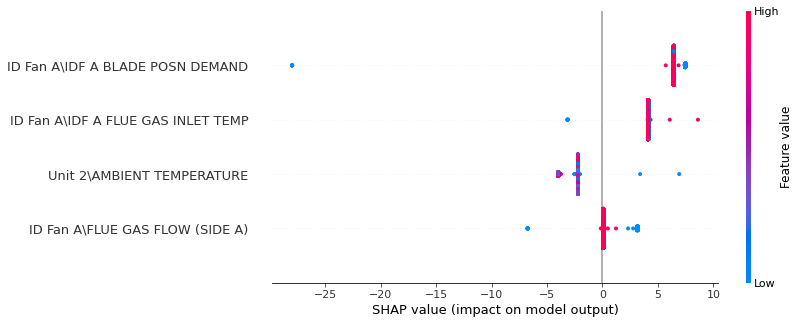

In [18]:
shap.summary_plot(shap_values, valid_x[features], plot_size=(10,5))